In [1]:
import matplotlib.pyplot as plt
import numpy as np
from neurolib.models.multimodel import MultiModel
from neurolib.models.multimodel.builder import HopfNetwork
from neurolib.utils.functions import getPowerSpectrum
from neurolib.utils.stimulus import ZeroInput

from hopf_cfc_network import SlowFastHopfNetwork
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch

import h5py
from cfcUtils import phase_locking_value

plt.style.use("seaborn")

# w instrinsic
# 0.003 ~ 0.5Hz
# 0.005 ~ 0.8Hz
# 0.01 ~ 2Hz
# 0.05 ~ 8Hz
# 0.06 ~ 10Hz
# 0.08 ~ 12Hz
# 0.1 ~ 17Hz
# 0.2 ~ 32Hz
# 0.3 ~ 50Hz

In [2]:
DURATION = 20.0 * 1000  # ms
DT = 0.1  # ms

In [3]:
def simulate(slow_to_fast_conn=0.1, fast_to_slow_conn=0.08, fast_frequency = 0.2, slow_frequency = 0.04):
    model = MultiModel(
        SlowFastHopfNetwork(
            number_of_slow_fast_units=1,
            slow_to_fast_connection=slow_to_fast_conn,
            fast_to_slow_connection=fast_to_slow_conn,
        )
    )
    model.params["duration"] = DURATION
    model.params["sampling_dt"] = DT
    model.params["dt"] = DT
    model.params['SlowFastHopfNet.SlowHopf_0.HopfMass_0.w'] = slow_frequency
    model.params['SlowFastHopfNet.FastHopf_1.HopfMass_0.w'] = fast_frequency

    model.run()

    return model

In [4]:
model = simulate(slow_to_fast_conn=0.5,fast_to_slow_conn=0.5)

/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/jitcdde/_jitcdde.py:1492: UserWarning: Your input past does not begin at t=0 but at t=0.1. Values before the beginning of the past will be extrapolated. You very likely do not want this.
  warn(f"Your input past does not begin at t=0 but at t={input[0].time}. Values before the beginning of the past will be extrapolated. You very likely do not want this.")
/tmp/tmpsr1mj42c/jitced.c: In function ‘get_past_anchors’:
/tmp/tmpsr1mj42c/jitced.c:176: warning: ignoring #pragma omp atomic [-Wunknown-pragmas]
  176 |  #pragma omp atomic capture
      | 
/tmp/tmpsr1mj42c/jitced.c:190: warning: ignoring #pragma omp critical [-Wunknown-pragmas]
  190 |   #pragma omp critical(pws)
      | 
/tmp/tmpsr1mj42c/jitced.c: In function ‘get_recent_state’:
/tmp/tmpsr1mj42c/jitced.c:285: warning: ignoring #pragma omp parallel [-Wunknown-pragmas]
  285 |  #pragma omp parallel for schedule(dynamic, 1)
  

Using default integration parameters.


  0%|          | 0/200000 [00:00<?, ?it/s]/home/lauraflyra/Documents/BCCN/Lab_Rotation_CFC/Hopf_CFC/Hopf_CFC_analysis/venv/lib/python3.8/site-packages/jitcdde/_jitcdde.py:792: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.
  warn("The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry.")
1

In [5]:
phase_slow = np.arctan2(model.y[0, :], model.x[0, :])

amp_fast = np.sqrt(model.x[1, :] ** 2 + model.y[1, :] ** 2)
phase_fast = np.arctan2(model.y[1, :], model.x[1, :])

In [6]:
plv_one_to_one = phase_locking_value(phase_fast,phase_slow)

In [7]:
np.abs(plv_one_to_one)

0.4107024041266561

In [8]:
fast_frequency = 0.2
slow_frequency = 0.04

ratio = fast_frequency/slow_frequency

In [9]:
ratio

5.0

In [10]:
plv_one_to_five = phase_locking_value(phase_fast,phase_slow, n=1,m=5)

In [11]:
np.abs(plv_one_to_five)

0.2203844562313803

In [12]:
plv_five_to_one = phase_locking_value(phase_fast, phase_slow, n=5, m=1)

In [13]:
np.abs(plv_five_to_one)

0.4134236561544267

In [14]:
plv_ten_to_two = phase_locking_value(phase_fast, phase_slow, n=10, m=2)
np.abs(plv_ten_to_two)

0.19090159816725635

In [15]:
n_list, m_list = np.meshgrid(np.arange(1,11,1),np.arange(1,11,1),sparse=True)

In [16]:
plv_list = np.zeros((10,10))
for n in n_list.T:
    for m in m_list:
        plv_list[n-1,m-1] = np.abs(phase_locking_value(phase_fast, phase_slow, n=n, m=m))

/tmp/ipykernel_11732/3254863360.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


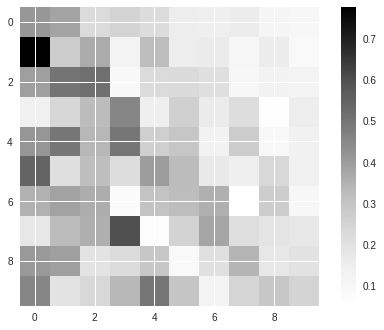

In [17]:
plt.imshow(plv_list)
plt.colorbar()

In [18]:
np.where(np.max(plv_list))

(array([0]),)

In [19]:
plv_list[1,0]

0.777034900696119

NameError: name 'slow_to_fast' is not defined

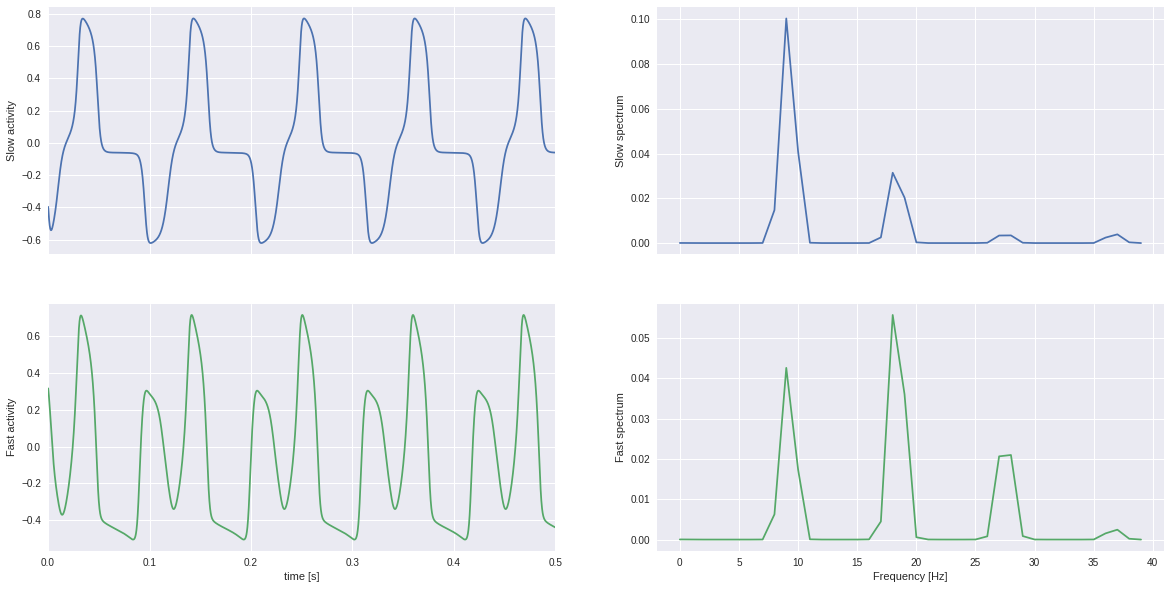

In [20]:
_, axs = plt.subplots(nrows=2, ncols=2, sharex="col", figsize=(20, 10))

axs[0, 0].plot(model.t, model.x.T[:, 0])
axs[0, 0].set_ylabel("Slow activity")
axs[1, 0].plot(model.t, model.x.T[:, 1], color="C1")
axs[1, 0].set_ylabel("Fast activity")
axs[1, 0].set_xlabel("time [s]")
freq_slow, pow_slow = getPowerSpectrum(model.x.T[:, 0], dt=0.1, maxfr=40, spectrum_windowsize=1)
axs[0, 1].plot(freq_slow, pow_slow)
axs[0, 1].set_ylabel("Slow spectrum")
freq_fast, pow_fast = getPowerSpectrum(model.x.T[:, 1], dt=0.1, maxfr=40, spectrum_windowsize=1)
axs[1, 1].plot(freq_fast, pow_fast, color="C1")
axs[1, 1].set_ylabel("Fast spectrum")
axs[1, 1].set_xlabel("Frequency [Hz]")

axs[0, 0].set_xlim([0, 0.5])
plt.suptitle(f"slow -> fast connection: {slow_to_fast} fast -> slow connection: {fast_to_slow} max in freq_fast {freq_fast[np.argmax(pow_fast)]} max in freq_slow {freq_slow[np.argmax(pow_slow)]}")
plt.show()

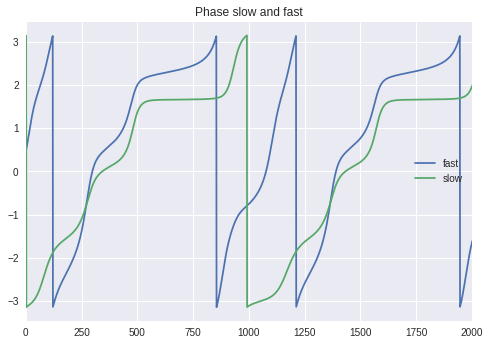

In [28]:
plt.plot(phase_fast,label="fast")
plt.plot(phase_slow, label="slow")
plt.xlim(0,2000)
plt.title("Phase slow and fast")
plt.legend()

In [30]:
plv_list

array([[0.4107024 , 0.38141642, 0.22190765, 0.24742327, 0.22038446,
        0.15638681, 0.14813386, 0.15801132, 0.11123835, 0.09630616],
       [0.7770349 , 0.27273317, 0.36593763, 0.1216529 , 0.32308486,
        0.15601761, 0.16176516, 0.1084101 , 0.15913154, 0.08609498],
       [0.39391254, 0.5011756 , 0.51368817, 0.09349493, 0.22320195,
        0.2251472 , 0.21041576, 0.10196631, 0.12996274, 0.12123166],
       [0.14157979, 0.23786406, 0.32601249, 0.45659655, 0.14583015,
        0.2597797 , 0.15993785, 0.21635091, 0.05970816, 0.15467863],
       [0.41342366, 0.49408907, 0.33748069, 0.49539625, 0.26399306,
        0.29528145, 0.13014806, 0.27480059, 0.09013462, 0.13611926],
       [0.54278699, 0.20831119, 0.3198381 , 0.21869816, 0.3949442 ,
        0.32584932, 0.16854267, 0.14451878, 0.23477002, 0.1326503 ],
       [0.35183081, 0.38404591, 0.36012253, 0.07334912, 0.30255181,
        0.32135396, 0.35313314, 0.05183468, 0.27024919, 0.09599037],
       [0.17772727, 0.32506558, 0.3560064